In [21]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import os

base_path = "/home/olivia/Sim2Real/fair/logdir/" # TODO: replace
series_name = "sim/test/return"
file_name = "arr.csv" # TODO: replace
data_dict_outer = {}
data_dict = {}
env = 'dmc_cup_catch'

In [22]:
from tensorflow.python.summary.summary_iterator import summary_iterator

In [23]:
def parse_tf_events_file(folder_name, series_name=series_name):
    if not folder_name[-1] == "/":
        folder_name = folder_name + "/"
    all_files = os.listdir(folder_name)
    file_name = [f for f in all_files if "events.out.tfevents" in f][0]
    file_name = folder_name + file_name
    eval_returns = []
    for e in summary_iterator(file_name):
        for v in e.summary.value:
            if v.tag == series_name:
#                 print(dir(v))
                x = tf.make_ndarray(v.tensor)
#                 print(x, v.simple_value)
                eval_returns.append([e.step,x])
    all_data = pd.DataFrame(data=eval_returns, columns=["Steps","Returns"])
    return all_data

def parse_csv_file(file_name):
    return pd.read_csv(file_name).values[:,2]

def plot(file_names, legend, x_label, y_label, title, save_name=False, last_bold=False, scale=1, 
         load_from_tb=False, base_dir=None, file_name=file_name, avg_every=None):
    for run_name in file_names:
        if load_from_tb:
            if base_dir is not None:
                    full_file_name = os.path.join(base_dir, run_name)
            csv = parse_tf_events_file(full_file_name)
        else:
            if base_dir is not None:
                full_file_name = os.path.join(base_dir, run_name, file_name)
            csv = parse_csv_file(full_file_name)
        if avg_every:
            csv = csv.rolling(window=avg_every).mean()
        
        x = np.array(range(len(csv))) * scale
        plt.plot(x, csv)
    if legend:
        plt.legend(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0, 1000)
    plt.title(title)
    if save_name:
        plt.savefig(save_name)
    plt.show()

    
def plot_avg(file_names_list, legend, x_label, y_label, title, save_name=False, last_bold=False, scale=1, 
             load_from_tb=False, base_dir=None, file_name=file_name, avg_every=None, clip_to=None):
    for file_names in file_names_list:
        runs = []
        steps = None
        for run_name in file_names:
            if load_from_tb:
                if base_dir is not None:
                    full_file_name = os.path.join(base_dir, run_name)
                out = parse_tf_events_file(full_file_name)
                csv = pd.DataFrame(data=out['Returns'].values, columns=['Returns'])
                steps = out['Steps'].values.astype(int)/1000
            else:
                if base_dir is not None:
                    full_file_name = os.path.join(base_dir, run_name, file_name)
                csv = parse_csv_file(full_file_name)
            if avg_every:
                csv = csv.ewm(span=avg_every).mean()#(window=avg_every).mean()
            runs.append(csv)
        if len(runs) > 0:
            min_len = min([len(run) for run in runs])
            if clip_to is not None:
                min_len = min(clip_to, min_len)
                if steps is not None:
                    min_len = np.where(steps > clip_to * 10)[0][0]
            
            runs = [run[:min_len] for run in runs]
            mean_arr = np.mean(np.stack(runs), axis=0)
            std_arr = np.std(np.stack(runs), axis=0)

            if len(mean_arr.shape) > 1:
                mean_arr = mean_arr[:, 0]
                std_arr = std_arr[:, 0]
            if steps is not None:
                x = steps[:min_len]
            else:
                x = np.array(range(len(mean_arr))) * scale
            print("plotting", file_names, len(x))
            plt.plot(x, mean_arr)
            plt.fill_between(x, mean_arr - std_arr, mean_arr + std_arr, alpha=0.2)
        else:
            print("no runs for", full_file_name)
    if legend:
        plt.legend(legend)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if save_name:
        plt.savefig(save_name)
    plt.show()


In [24]:
ratio_dict = {
    "1:1": 0,
    "10:1": 1,
    "100:1": 2,
    "No real": 3,
}
outer_loop_dict = {
    "No outer loop": 1 ,
    "Outer loop 1": 2,
    "Outer loop 2": 3,
}
seed_dict = {
    "1": 1,
    "2": 2,
    "3": 3,
    "4": 4,
}


condition_dict = {
    "Condition 1: Accurate, precise (correct mass)": 0,
    "Condition 2: Accurate, imprecise (correct mass)": 1,
    "Condition 3: Inaccurate, precise (small mass)": 2,
    "Condition 4: Inaccurate, imprecise* (small mass)": 3,
    "Condition 5: Inaccurate, imprecise (small mass)": 4,
    "Condition 6: Inaccurate, precise (large mass)": 5,
    "Condition 7: Inaccurate, imprecise* (large mass)": 6,
    "Condition 8: Inaccurate, imprecise (large mass)": 7,
}





def filter_by_ratio(files, condition):
    value = str(ratio_dict[condition])
    return list(filter(lambda x: x[2] == value, files))

def filter_by_outer_loop(files, condition):
    value = str(outer_loop_dict[condition])
    return list(filter(lambda x: x[1] == value, files))

def filter_by_seed(files, condition):
    value = str(seed_dict[condition])
    return list(filter(lambda x: x[5] == value, files))

def filter_by_condition(files, condition):
    value = str(condition_dict[condition])
    return list(filter(lambda x: x[3] == value, files))

def filter_by_env(files):
    return list(filter(lambda x: env in x, files))

# No Outer Loop

['0134_0-dmc_cup_catch-dreamer', '0110_0-dmc_cup_catch-dreamer', '0100_0-dmc_cup_catch-dreamer', '0124_0-dmc_cup_catch-dreamer', '0120_0-dmc_cup_catch-dreamer', '0104_0-dmc_cup_catch-dreamer', '0114_0-dmc_cup_catch-dreamer', '0130_0-dmc_cup_catch-dreamer', '0103_1-dmc_cup_catch-dreamer', '0135_2-dmc_cup_catch-dreamer', '0111_2-dmc_cup_catch-dreamer', '0127_1-dmc_cup_catch-dreamer', '0101_2-dmc_cup_catch-dreamer', '0137_1-dmc_cup_catch-dreamer', '0113_1-dmc_cup_catch-dreamer', '0125_2-dmc_cup_catch-dreamer', '0121_2-dmc_cup_catch-dreamer', '0117_1-dmc_cup_catch-dreamer', '0133_1-dmc_cup_catch-dreamer', '0105_2-dmc_cup_catch-dreamer', '0123_1-dmc_cup_catch-dreamer', '0115_2-dmc_cup_catch-dreamer', '0131_2-dmc_cup_catch-dreamer', '0107_1-dmc_cup_catch-dreamer', '0110_1-dmc_cup_catch-dreamer', '0126_2-dmc_cup_catch-dreamer', '0102_2-dmc_cup_catch-dreamer', '0134_1-dmc_cup_catch-dreamer', '0112_2-dmc_cup_catch-dreamer', '0124_1-dmc_cup_catch-dreamer', '0100_1-dmc_cup_catch-dreamer', '0136_2

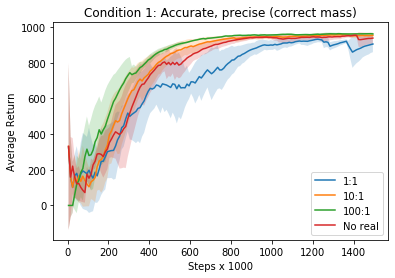

plotting ['0101_2-dmc_cup_catch-dreamer', '0101_0-dmc_cup_catch-dreamer', '0101_1-dmc_cup_catch-dreamer'] 150
plotting ['0111_2-dmc_cup_catch-dreamer', '0111_0-dmc_cup_catch-dreamer', '0111_1-dmc_cup_catch-dreamer'] 150
plotting ['0121_2-dmc_cup_catch-dreamer', '0121_0-dmc_cup_catch-dreamer', '0121_1-dmc_cup_catch-dreamer'] 150
plotting ['0131_2-dmc_cup_catch-dreamer', '0131_0-dmc_cup_catch-dreamer', '0131_1-dmc_cup_catch-dreamer'] 150


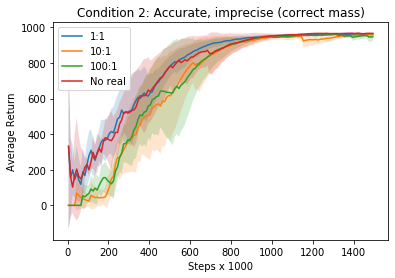

plotting ['0102_2-dmc_cup_catch-dreamer', '0102_1-dmc_cup_catch-dreamer', '0102_0-dmc_cup_catch-dreamer'] 150
plotting ['0112_2-dmc_cup_catch-dreamer', '0112_1-dmc_cup_catch-dreamer', '0112_0-dmc_cup_catch-dreamer'] 150
plotting ['0122_2-dmc_cup_catch-dreamer', '0122_1-dmc_cup_catch-dreamer', '0122_0-dmc_cup_catch-dreamer'] 150
plotting ['0132_2-dmc_cup_catch-dreamer', '0132_1-dmc_cup_catch-dreamer', '0132_0-dmc_cup_catch-dreamer'] 150


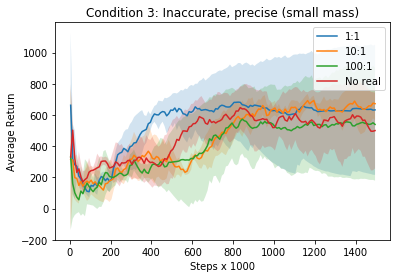

plotting ['0103_1-dmc_cup_catch-dreamer', '0103_0-dmc_cup_catch-dreamer', '0103_2-dmc_cup_catch-dreamer'] 150
plotting ['0113_1-dmc_cup_catch-dreamer', '0113_0-dmc_cup_catch-dreamer', '0113_2-dmc_cup_catch-dreamer'] 150


IndexError: index 0 is out of bounds for axis 0 with size 0

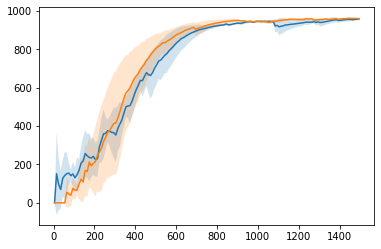

In [25]:

load_from_tb = True # TODO: change this if we have an actual TB directory!
files = os.listdir(base_path)
files = filter_by_env(files)
files = filter_by_outer_loop(files, "No outer loop")
print(files)


# Loop through different conditions:
for condition in condition_dict.keys():
    
    if condition in data_dict:
        plot_files, labels = data_dict
    else:
    
        condition_files = filter_by_condition(files, condition)
        # Generate a single plot for each condition
        plot_files = []
        labels = []
        for ratio in ratio_dict.keys():
            #         if ratio == "No real":
    #             print("current ratio files", len(ratio_files))
    #             all_files = os.listdir("logdir")
    #             ratio_files = filter_by_condition(filter_by_outer_loop(filter_by_ratio(all_files, ratio),                                                
            ratio_files = filter_by_ratio(condition_files, ratio)
            if len(ratio_files) > 0:
                plot_files.append(ratio_files)
                labels.append(ratio)
            
        data_dict[condition] = (plot_files, labels)
        
    # plot_files is just a list of names, so we could list the names manually if the exp names aren't
    # consistent enough to use the loop above.
    plot_avg(plot_files, labels, "Steps x 1000", "Average Return", condition, 
             save_name=f"noouter_{condition}.png", base_dir=base_path,
             avg_every=25, load_from_tb=load_from_tb, scale=100, clip_to=150)

#kangaroo

# Outer Loop

plotting ['0120', '01200'] 150
plotting ['0220', '02200'] 299


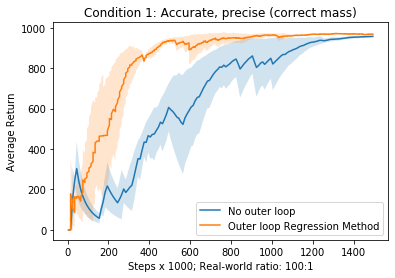

plotting ['01210', '0121'] 150
plotting ['02210', '0221'] 299


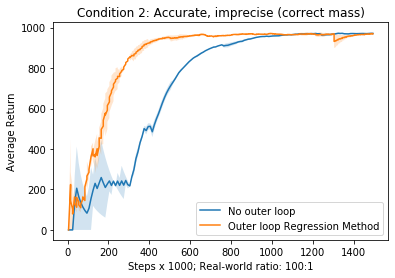

plotting ['01220', '0122'] 150
plotting ['02220', '0222'] 299


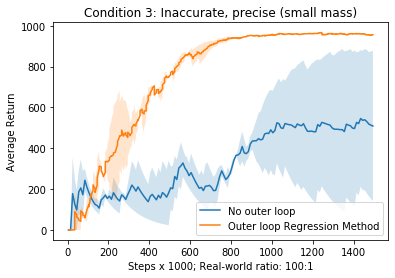

plotting ['01230', '0123'] 150
plotting ['02230', '0223'] 299


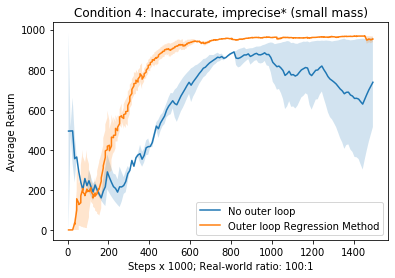

plotting ['0124', '01240'] 150
plotting ['02240', '0224'] 299


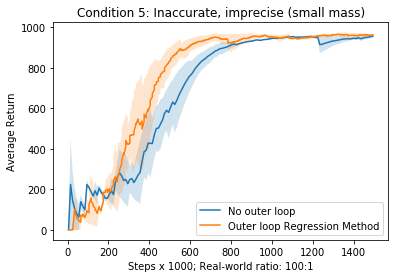

plotting ['01250', '0125'] 150
plotting ['022500', '02250', '0225_95', '0225'] 299


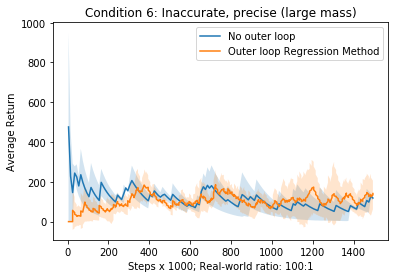

plotting ['01260', '0126'] 150
plotting ['0226_95'] 299


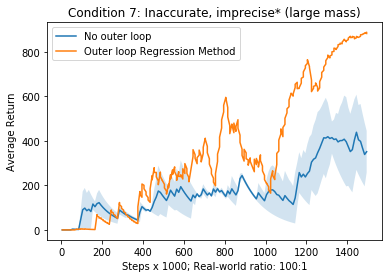

plotting ['0127', '01270'] 150
plotting ['0227_95', '02270'] 299


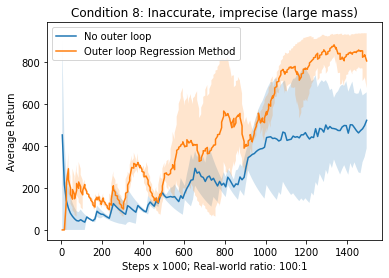

In [6]:

ratio = "100:1" # or we could loop through multiple values for this
load_from_tb = True # TODO: change this if we have an actual TB directory!
files = os.listdir(base_path)
# Loop through different conditions:
for condition in condition_dict.keys():
    
    if condition + ratio in data_dict_outer:
        plot_files, labels = data_dict
    else:
        
        condition_files = filter_by_condition(files, condition)
        # Generate a single plot for each condition
        plot_files = []
        labels = []
        
        ratio_files = filter_by_ratio(condition_files, ratio)
        no_outer_files = filter_by_outer_loop(ratio_files, "No outer loop")
        outer_files = filter_by_outer_loop(ratio_files, "Outer loop 1")
        plot_files = [no_outer_files, outer_files]
        labels = ["No outer loop", "Outer loop Regression Method"]
        data_dict_outer[condition + ratio] = (plot_files, labels)
    
    # plot_files is just a list of names, so we could list the names manually if the exp names aren't
    # consistent enough to use the loop above.
    plot_avg(plot_files, labels, "Steps x 1000; Real-world ratio: " + ratio, "Average Return", condition, 
             save_name=f"outer_{condition}_{ratio}.png", base_dir=base_path,
             avg_every=25, load_from_tb=load_from_tb, scale=100, clip_to=200)

# penguin

plotting ['0110', '01100'] 150
plotting ['0210'] 299


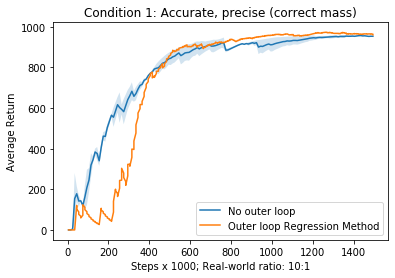

plotting ['0111', '01110'] 150
plotting ['0211'] 299


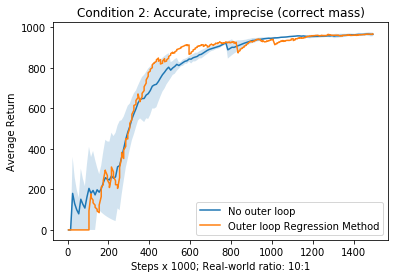

plotting ['01120', '0112'] 150
plotting ['0212'] 299


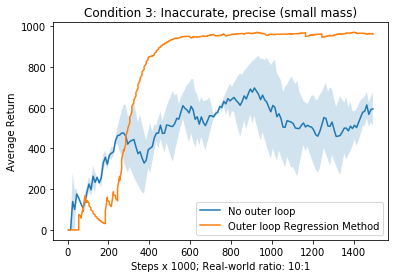

plotting ['01130', '0113'] 150
plotting ['0213'] 299


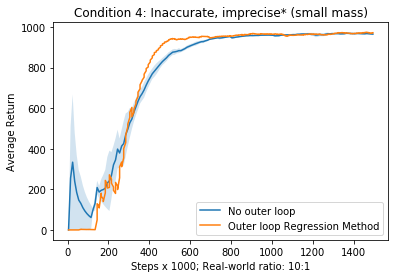

plotting ['01140', '0114'] 150
plotting ['0214'] 299


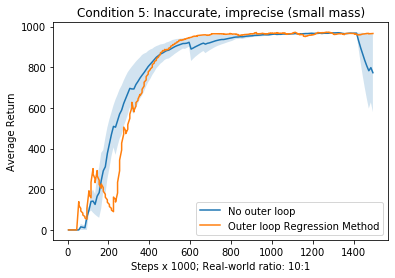

plotting ['0115'] 150
no runs for logdir/dmc_cup_catch/dreamer/0115


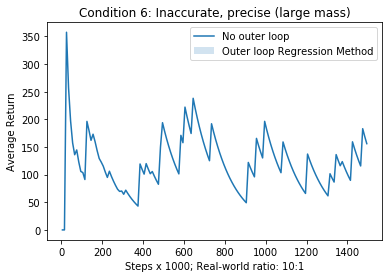

plotting ['0116'] 150
no runs for logdir/dmc_cup_catch/dreamer/0116


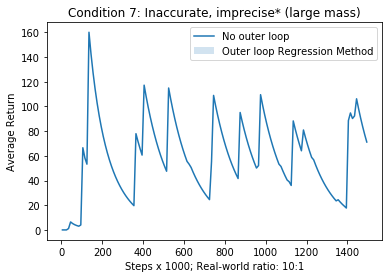

plotting ['0117'] 150
no runs for logdir/dmc_cup_catch/dreamer/0117


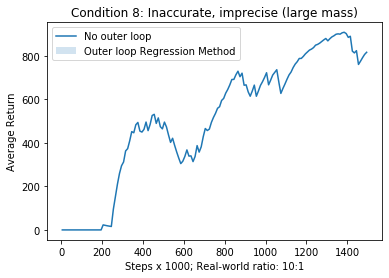

In [7]:

ratio = "10:1" # or we could loop through multiple values for this
load_from_tb = True # TODO: change this if we have an actual TB directory!
files = os.listdir(base_path)
# Loop through different conditions:
for condition in condition_dict.keys():
    
    if condition + ratio in data_dict_outer:
        plot_files, labels = data_dict
    else:
        
        condition_files = filter_by_condition(files, condition)
        # Generate a single plot for each condition
        plot_files = []
        labels = []
        
        ratio_files = filter_by_ratio(condition_files, ratio)
        no_outer_files = filter_by_outer_loop(ratio_files, "No outer loop")
        outer_files = filter_by_outer_loop(ratio_files, "Outer loop 1")
        plot_files = [no_outer_files, outer_files]
        labels = ["No outer loop", "Outer loop Regression Method"]
        data_dict_outer[condition + ratio] = (plot_files, labels)
    
    # plot_files is just a list of names, so we could list the names manually if the exp names aren't
    # consistent enough to use the loop above.
    plot_avg(plot_files, labels, "Steps x 1000; Real-world ratio: " + ratio, "Average Return", condition, 
             save_name=f"outer_{condition}_{ratio}.png", base_dir=base_path,
             avg_every=25, load_from_tb=load_from_tb, scale=100, clip_to=150)

# penguin

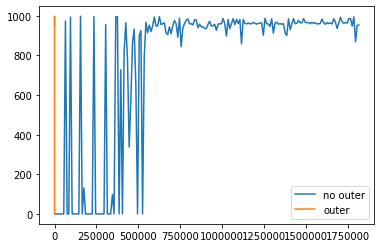

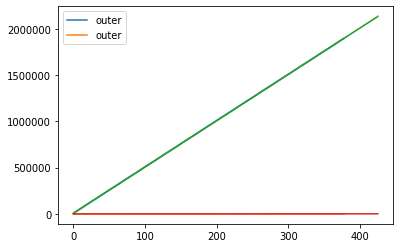

In [26]:
noouter1 = parse_tf_events_file("logdir/dmc_cup_catch/dreamer/0124")
noouter2 = parse_tf_events_file("logdir/dmc_cup_catch/dreamer/02240")
plt.plot(noouter1['Steps'], noouter1['Returns'])
plt.plot(range(len(noouter1)), noouter1['Returns'])
plt.legend(["no outer", "outer"])
plt.show()
outer1 = parse_tf_events_file("logdir/dmc_cup_catch/dreamer/0224")
outer2 = parse_tf_events_file("logdir/dmc_cup_catch/dreamer/02240")
plt.plot(range(len(outer1)), outer1)
plt.plot(range(len(outer2)), outer2)
plt.legend(["outer", "outer"])
plt.show()




In [17]:
window = 10

no1 = noouter1.rolling(window).mean()
no2 = noouter2.rolling(window).mean()
o1 = outer1.rolling(window).mean()
o2 = outer2.rolling(window).mean()

# plt.plot(range(len(no1)), no1.to_numpy()[:, 0])
# plt.plot(range(len(no2)), no2.to_numpy()[:, 0])
# plt.plot(range(len(o1)), o1.to_numpy()[:, 0])
# plt.plot(range(len(o1e.)), o2.to_numpy()[:, 0])

plt.plot(no1, 'lightblue', no1.rolling(window).mean(), 'b')
plt.plot(no2, 'lightgreen', no1.rolling(window).mean(), 'g')
plt.plot(o1, 'pink', no1.rolling(window).mean(), 'r')
plt.plot(o2, 'yellow', no1.rolling(window).mean(), 'o')
plt.legend(["outer", "outer", "no outer", "no outer"])
plt.show()

NameError: name 'noouter1' is not defined

In [6]:
real_noouter1 = pd.read_csv("0124.csv")
real_noouter2 = pd.read_csv("01240.csv")
real_outer1 = pd.read_csv("0224.csv")
real_outer2 = pd.read_csv("02240.csv")

In [14]:
another_real_outer2 = pd.read_csv("another_02240.csv")
yet_another_real_outer2 = pd.read_csv("run-02240-tag-sim_test_return.csv")
better_another_real_outer2 = pd.read_csv("run-02240-tag-sim_test_return2.csv")


In [199]:

outer2 = parse_tf_events_file("logdir/dmc_cup_catch/dreamer/02240")
print(len(outer2))

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
987.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
6.0 0.0
0.0 0.0
0.0 0.0
26.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
919.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
982.0 0.0
528.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
587.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
963.0 0.0
445.0 0.0
324.0 0.0
0.0 0.0
833.0 0.0
0.0 0.0
779.0 0.0
992.0 0.0
0.0 0.0
871.0 0.0
0.0 0.0
908.0 0.0
75.0 0.0
12.0 0.0
0.0 0.0
354.0 0.0
996.0 0.0
93.0 0.0
794.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
557.0 0.0
45.0 0.0
959.0 0.0
993.0 0.0
0.0 0.0
654.0 0.0
840.0 0.0
0.0 0.0
957.0 0.0
879.0 0.0
947.0 0.0
777.0 0.0
891.0 0.0
970.0 0.0
882.0 0.0
743.0 0.0
931.0 0.0
953.0 0.0
802.0 0.0
946.0 0.0
775.0 0.0
649.0 0.0
711.0 0.0
967.0 0.0
997.0 0.0
726.0 0.0
895.0 0.0
840.0 0.0
937.0 0.0
965.0 0.0
915.0 0.0
864.0 0.0
835.0 0.0
899.0 0.0
834.0 0.0
953.0 0.0
944.0 0.0
953.0 0.0
915.0 0.0
858.0 0.0
8

In [15]:
print(len(another_real_outer2))
print(len(yet_another_real_outer2))
print(len(better_another_real_outer2))

214
10
426


In [160]:
print(real_noouter1.shape)
print(noouter1.shape)

(182, 3)
(182, 1)


In [175]:
real_outer2.shape

(214, 3)

In [176]:
real_outer1.shape

(190, 3)

In [177]:
outer1.shape

(379, 1)

In [178]:
outer2.shape

(426, 1)

In [179]:
outer2

,Returns
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
421,964.0
422,964.0
423,997.0
424,965.0


In [180]:
real_outer2

,Wall time,Step,Value
0,1.589215e+09,5000,0.0
1,1.589215e+09,15000,0.0
2,1.589216e+09,25000,0.0
3,1.589216e+09,35000,0.0
4,1.589217e+09,45000,0.0
...,...,...,...
209,1.589310e+09,2095000,965.0
210,1.589311e+09,2105000,958.0
211,1.589311e+09,2115000,964.0
212,1.589312e+09,2125000,965.0


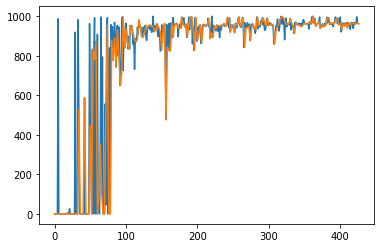

In [187]:
ax = [x * 2 for x in range(len(real_outer2))]
plt.plot(outer2["Returns"])
plt.plot(ax, real_outer2["Value"])
plt.show()

In [22]:
assert (noouter1["Returns"] == real_noouter1["Value"]).sum() == len(noouter1)
assert (noouter2["Returns"] == real_noouter2["Value"]).sum() == len(noouter2)
# assert (outer1["Returns"] == real_outer1["Value"]).sum() == len(outer1)
assert (outer2["Returns"] == better_another_real_outer2["Value"]).sum() == len(outer2)



In [162]:
eq.sum()

182

In [164]:
(~eq).sum()

0

plotting ['0110', '01100'] 150
plotting ['0210'] 150


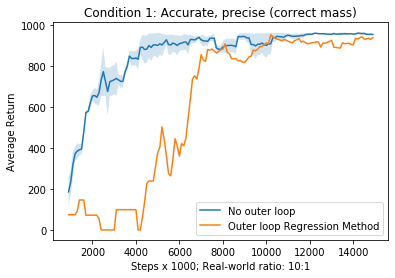

plotting ['0111', '01110'] 150
plotting ['0211'] 150


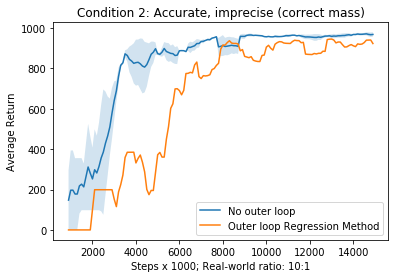

plotting ['01120', '0112'] 150
plotting ['0212'] 150


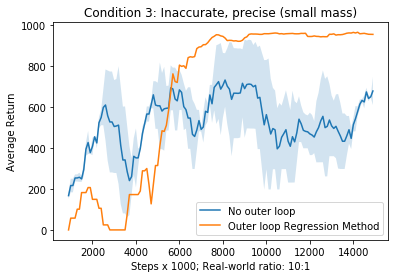

plotting ['01130', '0113'] 150
plotting ['0213'] 150


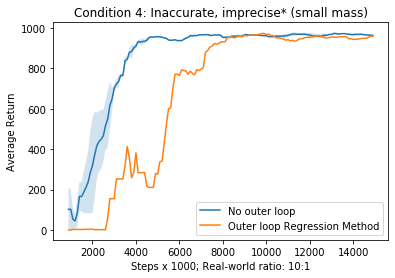

plotting ['01140', '0114'] 150
plotting ['0214'] 150


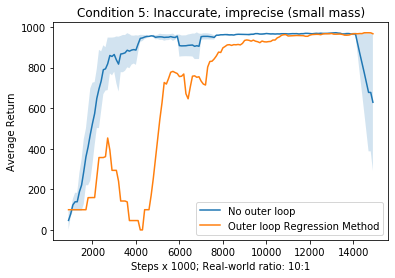

plotting ['0115'] 150
no runs for logdir/dmc_cup_catch/dreamer/0115


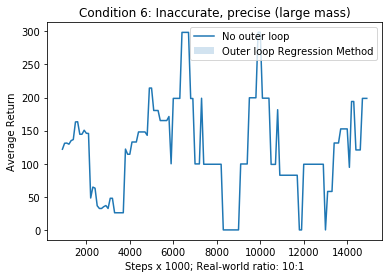

plotting ['0116'] 150
no runs for logdir/dmc_cup_catch/dreamer/0116


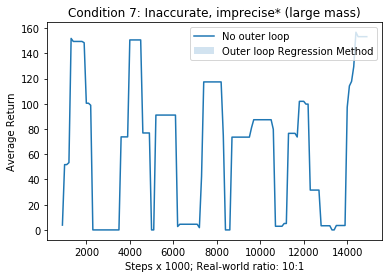

plotting ['0117'] 150
no runs for logdir/dmc_cup_catch/dreamer/0117


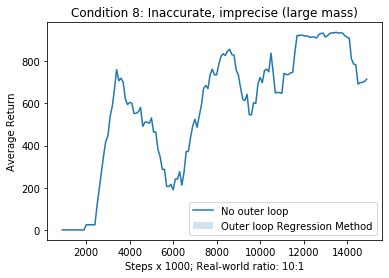

In [143]:
data_dict_outer = {}

ratio = "10:1" # or we could loop through multiple values for this
load_from_tb = True # TODO: change this if we have an actual TB directory!
files = os.listdir(base_path)
# Loop through different conditions:
for condition in condition_dict.keys():
    
    if condition + ratio in data_dict_outer:
        plot_files, labels = data_dict
    else:
        
        condition_files = filter_by_condition(files, condition)
        # Generate a single plot for each condition
        plot_files = []
        labels = []
        
        ratio_files = filter_by_ratio(condition_files, ratio)
        no_outer_files = filter_by_outer_loop(ratio_files, "No outer loop")
        outer_files = filter_by_outer_loop(ratio_files, "Outer loop 1")
        plot_files = [no_outer_files, outer_files]
        labels = ["No outer loop", "Outer loop Regression Method"]
        data_dict[condition + ratio] = (plot_files, labels)
    
    # plot_files is just a list of names, so we could list the names manually if the exp names aren't
    # consistent enough to use the loop above.
    plot_avg(plot_files, labels, "Steps x 1000; Real-world ratio: " + ratio, "Average Return", condition, 
             save_name=f"outer_{condition}_{ratio}.png", base_dir=base_path,
             avg_every=10, load_from_tb=load_from_tb, scale=100, clip_to=150)

# penguin

[['0100'], []]


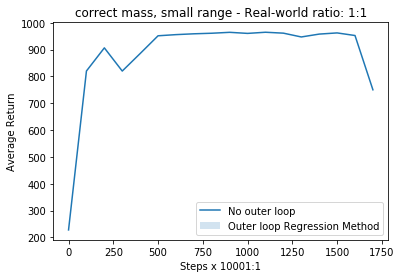

[['0101'], []]


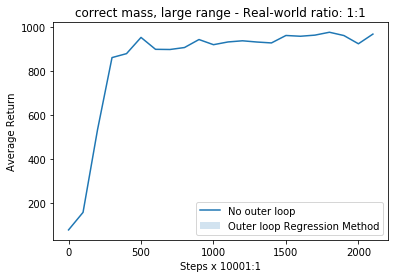

[['0102'], []]


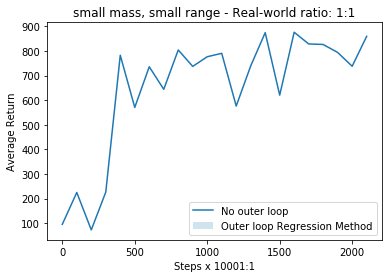

[['0103'], []]


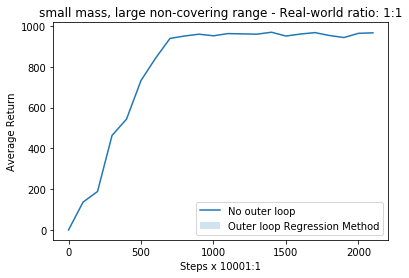

[['0104'], []]


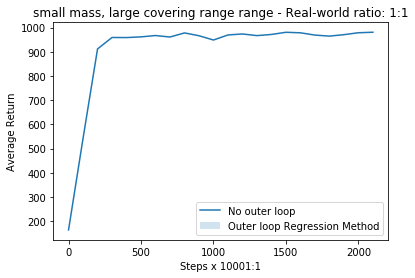

[['0105'], []]


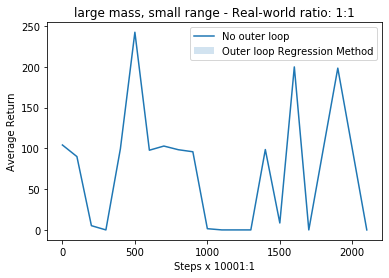

[['0106'], []]


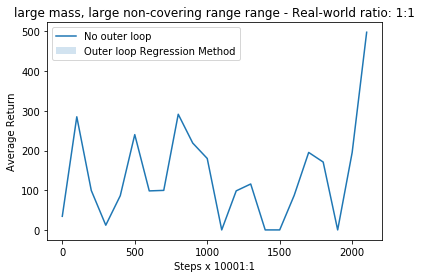

[['0107'], []]


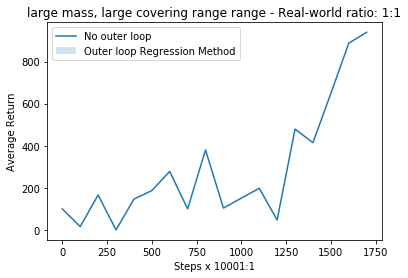

In [75]:
load_from_tb = True # TODO: change this if we have an actual TB directory!
files = os.listdir(base_path)
# Loop through different conditions:
for condition in condition_dict.keys():
    condition_files = filter_by_condition(files, condition)
    # Generate a single plot for each condition
    plot_files = []
    labels = []
    ratio = "1:1" # or we could loop through multiple values for this
    ratio_files = filter_by_ratio(condition_files, ratio)
    no_outer_files = filter_by_outer_loop(ratio_files, "No outer loop")
    outer_files = filter_by_outer_loop(ratio_files, "Outer loop 1")
    plot_files = [no_outer_files, outer_files]
    labels = ["No outer loop", "Outer loop Regression Method"]
    
    # plot_files is just a list of names, so we could list the names manually if the exp names aren't
    # consistent enough to use the loop above.
    print(plot_files)
    plot_avg(plot_files, labels, "Steps x 1000" + ratio, "Average Return", condition + " - Real-world ratio: " + ratio, 
             save_name=f"outer_{condition}.png", base_dir=base_path,
             avg_every=10, load_from_tb=load_from_tb, scale=100)

# penguin